### cli command for copping faces and saving

In [1]:
# default_exp face_detection.save_cropped_faces

In [2]:
from dfdc.core.core import *
from dfdc.core.video_core import *

In [3]:
from fastai.vision import *
from tqdm import tqdm

In [4]:
data_path = Path("/home/ubuntu/data/dfdc/")

In [5]:
video_path = data_path/"dfdc_train/dfdc_train_part_48"

In [6]:
metadata = get_files(video_path, extensions=['.json'])

In [7]:
video_files = get_files(video_path, extensions=['.mp4'])

In [8]:
metadf = read_metadata(metadata[0])

In [9]:
metadf.head()

,fname,label,split,original
0,noagmcpxfb.mp4,FAKE,train,dgtdgrzifi.mp4
1,alzbizkswy.mp4,REAL,train,NaN
2,xcmkbpzfzw.mp4,FAKE,train,aoqzxlwvmi.mp4
3,uywdjgfgqr.mp4,FAKE,train,oupjhtodai.mp4
4,fbqwomdehr.mp4,FAKE,train,xtixietgjp.mp4


In [10]:
metadf.groupby("label")[["fname",'original']].count()

,fname,original
label,,
FAKE,2041,2041
REAL,422,0


In [11]:
face_detections_df = pd.read_csv(data_path/'dfdc_face_detections/part_48_retina_detections.csv')
face_detections_df.face_detections = (face_detections_df.face_detections
                                                        .apply(lambda o: json.loads(o.replace("'", '"'))))

In [12]:
face_detections_df

,fname,size,face_detections,n_frames,sample_freq,len_video
0,tecrulzonc.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[809, 211, 943...",30,10,300
1,gvyvbdlfap.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[862, 196, 107...",30,10,300
2,vflaeohpdd.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[811, 219, 937...",30,10,300
3,jjioflapll.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[427, 436, 630...",30,10,300
4,scvkxznabj.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[707, 56, 843,...",30,10,300
...,...,...,...,...,...,...
2458,enuvbqyode.mp4,"(1920, 1080)","[{'frame_no': 0, 'detections': [[493, 676, 683...",30,10,300
2459,xjinzawywt.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[949, 112, 108...",30,10,300
2460,jdcoheaygf.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[1214, 360, 13...",30,10,300
2461,rmndwrumtv.mp4,"(1080, 1920)","[{'frame_no': 0, 'detections': [[885, 76, 1028...",30,10,300


In [13]:
Counter(face_detections_df['size'])

Counter({'(1080, 1920)': 2089, '(1280, 720)': 161, '(1920, 1080)': 213})

### `crop_and_save()`

In [14]:
#export 
from fastscript import call_parse, Param
from tqdm import tqdm
from fastai.vision import *
from dfdc.core.video_core import *
from dfdc.face_detection.bbox_utils import *

In [15]:
#export
def save(self, fn:PathOrStr, mult=False):
    "Save the image to `fn`."
    x = image2np(self.data*255 if mult else self.data).astype(np.uint8)
    PIL.Image.fromarray(x).save(fn)
Image.save = save # monkey patch

def _crop_and_save(path:PathOrStr, fname:PathOrStr, crop_path:PathOrStr, bboxes:List[List[List]],
                  freq, total_frames):
    """
    path: directory which has the video with fname
    fname: filename of video "xxxxx.mp4"
    crop_path: destination directory to save cropped images for video
    bboxes: list of bbox coordinates for each sampled frame for video
    freq: sample frequence used in bbox detection
    total_frames: total number of frames sampled from video during detection    
    """
    
    # read sampled raw video
    t, len_video = decord_cpu_video_reader(path/fname, freq)
    H,W = t.size(2), t.size(3)
    
    # create directory to save crops from a particular video
    video_dir = crop_path/Path(fname).stem
    os.makedirs(video_dir, exist_ok=True)
    
    # check if # of face detections are same as # of sampled frames
    assert len(bboxes) == t.size(0)
    
    rescale_param = 1.3
    for frame_no, (_frame, _bb) in enumerate(zip(t, bboxes)):
        # don't try cropping if no detection is available for the frame
        try: _bb[0] 
        except: continue
        # naive: get first bbox, optionally rescale
        left, top, right, bottom  = resize_bbox_by_scale(_bb[0], rescale_param, H, W) 
        # crop and save
        face_crop = Image(_frame[:, top:bottom, left:right])
        # save with frame index (start from 1) and sequence length (total available frames)
        save_path = video_dir/f"frame_{frame_no+1}_{total_frames}.jpg"
        face_crop.save(save_path)
    return crop_path

In [16]:
#export
@call_parse
def save_cropped_faces(video_directory:Param("Directory of videos", type=str), 
                       face_detections_csv:Param("CSV file which has face detections", type=str)
                        ):

    
    # read detections
    face_detections_df = pd.read_csv(face_detections_csv)
    face_detections_df.face_detections = (face_detections_df.face_detections
                                          .apply(lambda o: json.loads(o.replace("'", '"'))))
    
    # create directory to save images for all videos
    video_path = Path(video_directory)
    crop_path = data_path/"dfdc_cropped_faces"/video_path.name
    os.makedirs(crop_path, exist_ok=True)
    
    # crop and save 
    _, rows = list(zip(*face_detections_df.iterrows()))
    for row in tqdm(rows):
        fname = row['fname']
        face_detections = row['face_detections']
        bboxes = [o['detections'] for o in face_detections]
        freq = row['sample_freq']
        total_frames = row['n_frames']
        crop_path = _crop_and_save(video_path, fname, crop_path, bboxes, freq, total_frames)
    return crop_path

### Test command

In [23]:
video_directory = '/home/ubuntu/data/dfdc/dfdc_train/dfdc_train_part_49'
face_detections_csv = '/home/ubuntu/data/dfdc/dfdc_face_detections/part_49_retina_detections.csv'

In [24]:
save_cropped_faces(video_directory, face_detections_csv)

100%|██████████| 3134/3134 [36:59<00:00,  1.41it/s]


PosixPath('/home/ubuntu/data/dfdc/dfdc_cropped_faces/dfdc_train_part_49')

### Visualize Crops

In [25]:
crop_path = Path('/home/ubuntu/data/dfdc/dfdc_cropped_faces/dfdc_train_part_49')

In [26]:
crop_folders = crop_path.ls()

In [27]:
len(crop_folders)

3134

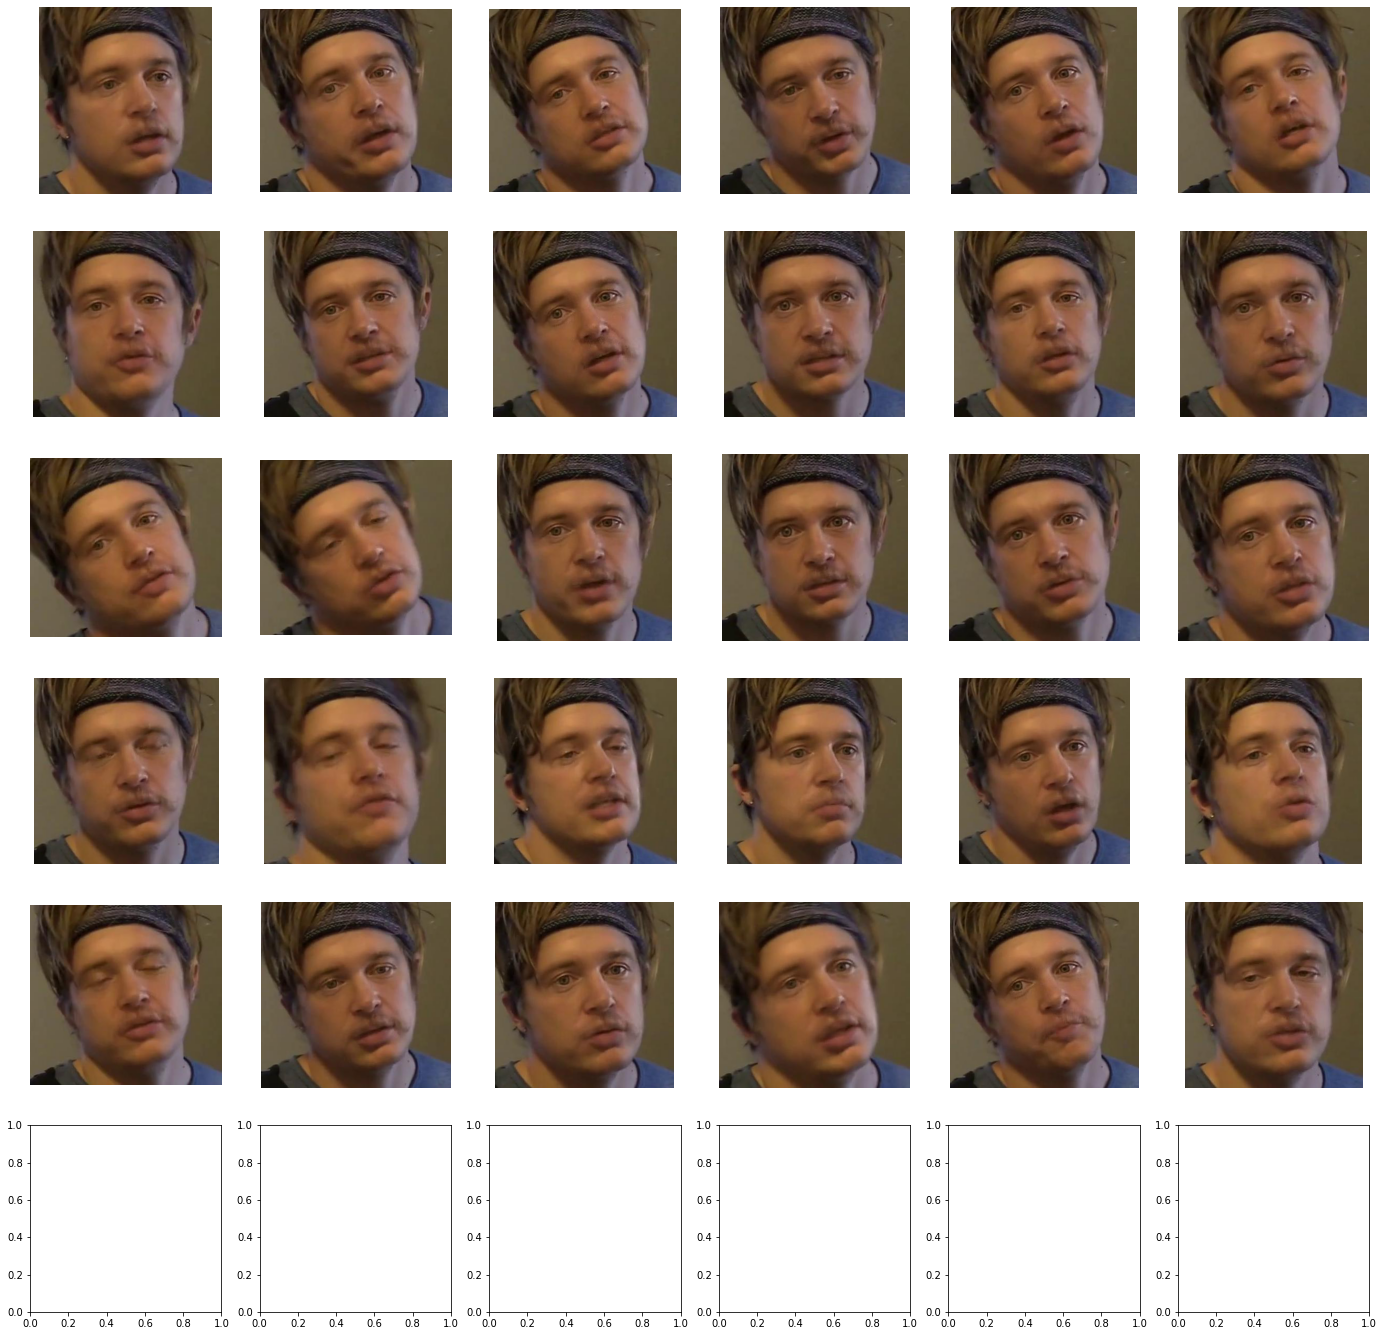

In [28]:
il = ImageList.from_folder(np.random.choice(crop_folders))
n = int(np.ceil(np.sqrt(len(il.items)))); n
axes = subplots(n,n).flatten()
for img, ax in zip(il, axes): img.show(ax=ax)

### export

In [29]:
from nbdev.export import notebook2script

In [30]:
notebook2script()

Converted 001 - extract_faces.ipynb.
Converted 002 - face_detection_retinaface.ipynb.
Converted 003 - save_face_crops.ipynb.
Converted 004 - tl_baseline.ipynb.
Converted 00_core.ipynb.
Converted 01_video_core.ipynb.
Converted 10_bbox_utils.ipynb.
Converted 11_retinaface_detection.ipynb.
Converted 12_generate_face_detections.ipynb.
Converted 13_save_cropped_faces.ipynb.
Converted 21_baseline_model.ipynb.
Converted index.ipynb.
